# UNet
Used this notebook to create a UNet autoencoder architecture in order to set a baseline of performance for input frames reconstruction

#### Check Autoencoder Params vs ResNet18
```
Autoencoder:
Computational complexity: 627.8 MMac
Computational complexity: 1255.6 MFlops
Number of parameters: 6.21 

ResNet 18:
Computational complexity: 1.83 GMac
Computational complexity: 3.66 GFlops
Number of parameters: 11 M M  

In [29]:
# import torchvision.models as models
# import torch
# from ptflops import get_model_complexity_info
# import re

# #Model thats already available
# # net = models.densenet161()
# macs, params = get_model_complexity_info(autoencoder, (3, 64, 64), as_strings=True, print_per_layer_stat=True, verbose=True)
# # Extract the numerical value
# flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# # Extract the unit
# flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

# print('Autoencoder:')
# print('Computational complexity: {:<8}'.format(macs))
# print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
# print('Number of parameters: {:<8}'.format(params))
# print()

# net = models.resnet18()
# macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=True)
# # Extract the numerical value
# flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# # Extract the unit
# flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

# print('ResNet 18:')
# print('Computational complexity: {:<8}'.format(macs))
# print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
# print('Number of parameters: {:<8}'.format(params))
# print()

In [69]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         # Define the encoder layers here (Contracting Path)
#         self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2)

#     def forward(self, x):
#         # Encoding/Contracting Path
#         x1 = F.relu(self.enc_conv1(x))
#         x1_p = self.pool(x1)
#         x2 = F.relu(self.enc_conv2(x1_p))
#         x2_p = self.pool(x2)
#         x3 = F.relu(self.enc_conv3(x2_p))
#         x3_p = self.pool(x3)
#         return [x1, x2, x3_p]

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         # Define the decoder layers here (Expansive Path)
#         self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.dec_conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.up_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.dec_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.final_conv = nn.Conv2d(64, 3, kernel_size=1)  # Assuming 3-channel output

#     def forward(self, features):
#         x1, x2, x3 = features
#         # Decoding/Expansive Path
#         up3 = self.up_conv3(x3)
#         dec3 = F.relu(self.dec_conv3(up3 + x2))  # Skip connection from the encoder
#         up2 = self.up_conv2(dec3)
#         dec2 = F.relu(self.dec_conv2(up2 + x1))  # Skip connection from the encoder
#         return self.final_conv(dec2)

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()

#     def forward(self, x):
#         enc_features = self.encoder(x)
#         return self.decoder(enc_features)

# # Initialize the model
# unet = UNet()

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# unet.to(device)

# # unet.load_state_dict(torch.load('.pth')['model_state_dict'])

# # # To freeze the encoder (for example, during training)
# # for param in model.encoder.parameters():
# #     param.requires_grad = False

UNet(
  (encoder): Encoder(
    (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (up_conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (dec_conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (up_conv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (final_conv): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [77]:
# UNet V1
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define the layers here
        self.down1 = self.contract_block(3, 64, 3, 1)
        self.down2 = self.contract_block(64, 128, 3, 1)
        self.down3 = self.contract_block(128, 256, 3, 1)
        self.up3 = self.expand_block(256, 128, 3, 1)
        self.up2 = self.expand_block(128 * 2, 64, 3, 1)
        self.up1 = self.expand_block(64 * 2, 64, 3, 1)
        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def __call__(self, x):
        # Downsample
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, kernel_size=2, stride=2))
        x3 = self.down3(F.max_pool2d(x2, kernel_size=2, stride=2))

        # Upsample
        x_up = self.up3(F.interpolate(x3, scale_factor=2))
        x_up = self.up2(F.interpolate(torch.cat([x_up, x2], 1), scale_factor=2))
        x_up = self.up1(torch.cat([x_up, x1], 1))

        return self.final(x_up)

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        return expand


unet = UNet().to(device)

# unet.load_state_dict(torch.load('unet_yolov3_norm_0.5_58.pth')['model_state_dict'])


# for param in unet.down1.parameters():
#     param.requires_grad = False
# for param in unet.down2.parameters():
#     param.requires_grad = False
# for param in unet.down3.parameters():
#     param.requires_grad = False

In [78]:
# unet.load_state_dict(torch.load('unet_35_mseloss_0.001003648154437542.pth')['model_state_dict'])
unet.load_state_dict(
    torch.load("unet_detr_norm_0.5_epoch_33_loss_0.0002582000459943847.pth")[
        "model_state_dict"
    ]
)
# unet.load_state_dict(torch.load('.pth')['model_state_dict'])

<All keys matched successfully>

In [63]:
resize_transform = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        T.Normalize(0.5, 0.5),
    ]
)

train_dataset = datasets.ImageFolder(
    root="./datasets/Avenue Dataset/objects_detr_resnet101_dc5/train/",
    transform=resize_transform,
)

# Create the DataLoader to load the dataset.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=6)

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 158867
    Root location: ./datasets/Avenue Dataset/objects_detr_resnet101_dc5/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [64]:
%%time
# Training loop
num_epochs = 40  # Define the number of epochs
losses = []
smallest_loss = 1
for epoch in range(15, num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:  # Note the unpacking here to ignore the labels
        # print(inputs.shape)
        inputs = inputs.to(device)  # Move inputs to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        reconstructed_imgs = unet(inputs)

        # Calculate loss
        loss = criterion(reconstructed_imgs, inputs)
        # print(reconstructed_imgs.shape)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

        losses.append(loss.item())

    if (running_loss / len(train_loader)) < smallest_loss:
        smallest_loss = running_loss / len(train_loader)
        # Save checkpoint
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": unet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": running_loss,
        }
        torch.save(
            checkpoint,
            f"unet_detr_norm_0.5_epoch_{epoch+1}_loss_{running_loss / len(train_loader)}.pth",
        )

    # Print loss every epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.8f}")
    running_loss = 0.0

print("Finished Training")

Epoch 16, Loss: 0.00034841
Epoch 17, Loss: 0.00035432
Epoch 18, Loss: 0.00031823
Epoch 19, Loss: 0.00032439
Epoch 20, Loss: 0.00029269
Epoch 21, Loss: 0.00031051
Epoch 22, Loss: 0.00028591
Epoch 23, Loss: 0.00029614
Epoch 24, Loss: 0.00029371
Epoch 25, Loss: 0.00031832
Epoch 26, Loss: 0.00028817
Epoch 27, Loss: 0.00026825
Epoch 28, Loss: 0.00027606
Epoch 29, Loss: 0.00027207
Epoch 30, Loss: 0.00026586
Epoch 31, Loss: 0.00030669
Epoch 32, Loss: 0.00027876
Epoch 33, Loss: 0.00025820
Epoch 34, Loss: 0.00026765
Epoch 35, Loss: 0.00025362
Epoch 36, Loss: 0.00028439
Epoch 37, Loss: 0.00027564
Epoch 38, Loss: 0.00028363
Epoch 39, Loss: 0.00026467
Epoch 40, Loss: 0.00027841
Finished Training
CPU times: user 58min 4s, sys: 54.3 s, total: 58min 58s
Wall time: 59min 21s


In [79]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    # img = std * img + mean  # unnormalize
    # img = np.clip(img, 0, 1)  # clip any values outside the range [0, 1]
    plt.imshow(img)
    plt.show()


def plot_images_vs_reconstructed_images(images, reconstructed_imgs):
    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed_imgs = reconstructed_imgs.cpu()

    # Display original and reconstructed images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Images")
    imshow(vutils.make_grid(images, padding=2, normalize=True))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Images")
    imshow(vutils.make_grid(reconstructed_imgs, padding=2, normalize=True))

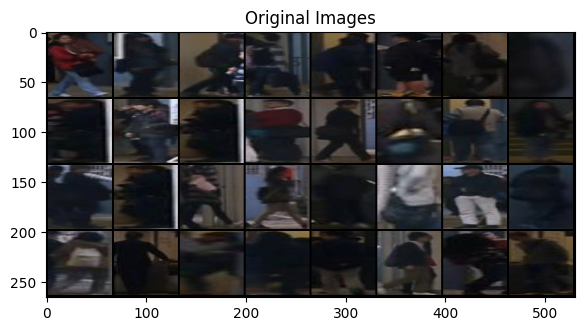

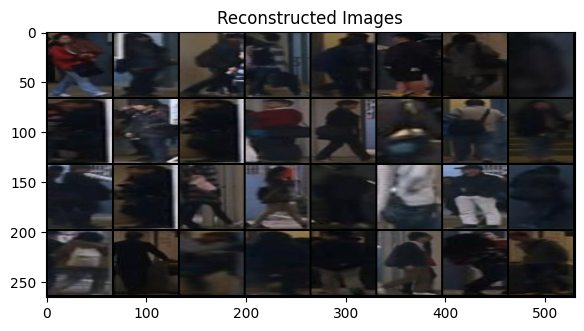

In [80]:
# Get a batch of images from your dataloader
dataiter = iter(train_loader)  # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    # latent_representation = encoder(images)[-1]  # Get the last latent space representation
    # print(latent_representation.shape)
    # reconstructed_imgs = decoder(latent_representation)
    reconstructed_imgs = unet(images)

plot_images_vs_reconstructed_images(images[:32], reconstructed_imgs[:32])

In [81]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in train_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            reconstructed_imgs = unet(images)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)

        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f"Average reconstruction loss on the train set: {average_loss}")

Average reconstruction loss on the train set: 0.0002730369574069132


In [84]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in test_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            reconstructed_imgs = unet(images)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)

        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f"Average reconstruction loss on the test set: {average_loss}")

Average reconstruction loss on the test set: 0.00429502251641803


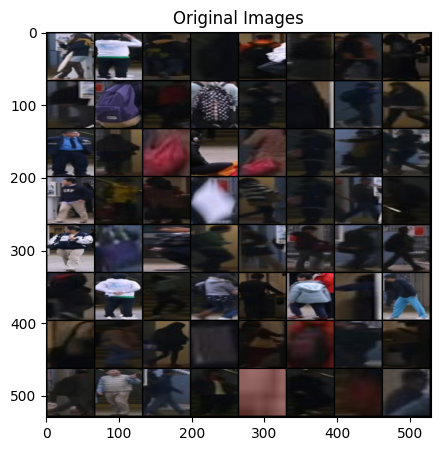

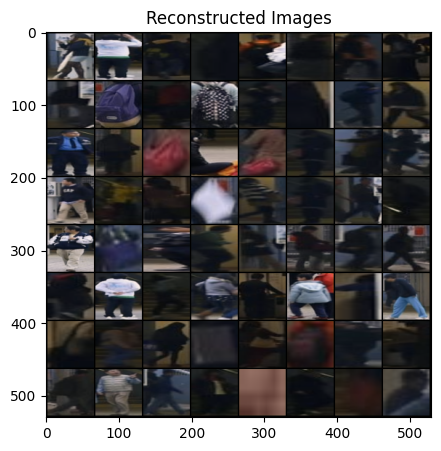

In [83]:
# Get a batch of images from your dataloader
dataiter = iter(test_loader)  # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    reconstructed_imgs = unet(images)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

In [85]:
# Read obj_det_avenue_test
with open("obj_dect_avenue_detr_resnet_50_dc5", "rb") as file:
    obj_dect_avenue = pickle.load(file)

In [86]:
obj_dect_avenue.keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])

In [87]:
# %%time
all_pred_ano = []
anomaly_scores_dict = {}
for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    bbox_temp = obj_dect_avenue[video_names[i]]
    anomaly_scores_dict[video_names[i]] = {}

    for frame_idx, image_name in zip(bbox_temp, image_names):
        full_image_path = os.path.join(test_video_paths[i], image_name)
        image = Image.open(full_image_path)
        boxes = bbox_temp[frame_idx]
        current_frame_max_anomaly_score = float("-inf")
        frame_anomaly_map = np.zeros(image.size[::-1])

        for bbox in boxes:
            cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
            transformed_obj = resize_transform(cropped_obj)

            transformed_obj = transformed_obj.unsqueeze(0)
            transformed_obj = transformed_obj.to(device)

            with torch.no_grad():
                reconstructed_img = unet(transformed_obj)

            cropped_obj_tensor = resize_transform(cropped_obj)
            cropped_obj_tensor = cropped_obj_tensor.unsqueeze(0).to(device)

            score = F.mse_loss(reconstructed_img, cropped_obj_tensor)
            frame_anomaly_map[
                int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
            ] += score.item()
            try:
                anomaly_score = frame_anomaly_map[
                    int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])
                ].max()
                all_pred_ano.append(
                    AnomalyDetection(
                        frame_idx, bbox, anomaly_score, video_names[i], track_id=-1
                    )
                )
            except:
                pass

        current_frame_max_anomaly_score = np.max(frame_anomaly_map)
        anomaly_scores_dict[video_names[i]][frame_idx] = current_frame_max_anomaly_score

./datasets/Avenue Dataset/test__/01
./datasets/Avenue Dataset/test__/02
./datasets/Avenue Dataset/test__/03
./datasets/Avenue Dataset/test__/04
./datasets/Avenue Dataset/test__/05
./datasets/Avenue Dataset/test__/06
./datasets/Avenue Dataset/test__/07
./datasets/Avenue Dataset/test__/08
./datasets/Avenue Dataset/test__/09
./datasets/Avenue Dataset/test__/10
./datasets/Avenue Dataset/test__/11
./datasets/Avenue Dataset/test__/12
./datasets/Avenue Dataset/test__/13
./datasets/Avenue Dataset/test__/14
./datasets/Avenue Dataset/test__/15
./datasets/Avenue Dataset/test__/16
./datasets/Avenue Dataset/test__/17
./datasets/Avenue Dataset/test__/18
./datasets/Avenue Dataset/test__/19
./datasets/Avenue Dataset/test__/20
./datasets/Avenue Dataset/test__/21


#### Compute FPR RBDR

In [74]:
compute_fpr_rbdr(
    all_pred_ano, gt_anomalies, all_gt_tracks, num_frames=15324, num_tracks=num_tracks
)

tbdc = 0.31849947470720585
rbdc = 0.4568716506961804


(0.4568716506961804, 0.31849947470720585)

In [75]:
aucs = []
filtered_preds = []
filtered_labels = []

for vid_name in anomaly_scores_dict:
    # print(len(anomaly_scores_dict[vid_name]))
    pred = np.array(list(score for score in anomaly_scores_dict[vid_name].values()))
    pred = process_current_vid_preds(pred)
    filtered_preds.append(pred)

    lbl = labels_dict[vid_name]
    filtered_labels.append(lbl)

    lbl = np.array([0] + list(lbl) + [1])
    pred = np.array([0] + list(pred) + [1])

    fpr, tpr, _ = metrics.roc_curve(lbl, pred)
    res = metrics.auc(fpr, tpr)
    aucs.append(res)

macro_auc = np.nanmean(aucs)
print(macro_auc)

0.788489862362223


In [76]:
# Micro-AUC
filtered_preds = np.concatenate(filtered_preds)
filtered_labels = np.concatenate(filtered_labels)

fpr, tpr, _ = metrics.roc_curve(filtered_labels, filtered_preds)
micro_auc = metrics.auc(fpr, tpr)
micro_auc = np.nan_to_num(micro_auc, nan=1.0)

print(micro_auc)

0.7820974341066705


#### Check U-Net params vs Resnet18

In [339]:
# Intre timp, pot sa inlocuiesc autoencoder-ul cu u-net (non-pretrained)
# Apoi sa compar resnet18 vs UNET (GMAC)

import torchvision.models as models
import torch
from ptflops import get_model_complexity_info
import re


# Model thats already available
# net = models.densenet161()
macs, params = get_model_complexity_info(
    unet, (3, 64, 64), as_strings=True, print_per_layer_stat=True, verbose=True
)
# Extract the numerical value
flops = eval(re.findall(r"([\d.]+)", macs)[0]) * 2
# Extract the unit
flops_unit = re.findall(r"([A-Za-z]+)", macs)[0][0]

print("UNet:")
print("Computational complexity: {:<8}".format(macs))
print("Computational complexity: {} {}Flops".format(flops, flops_unit))
print("Number of parameters: {:<8}".format(params))
print()

net = models.resnet18()
macs, params = get_model_complexity_info(
    net, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=True
)
# Extract the numerical value
flops = eval(re.findall(r"([\d.]+)", macs)[0]) * 2
# Extract the unit
flops_unit = re.findall(r"([A-Za-z]+)", macs)[0][0]

print("ResNet 18:")
print("Computational complexity: {:<8}".format(macs))
print("Computational complexity: {} {}Flops".format(flops, flops_unit))
print("Number of parameters: {:<8}".format(params))
print()

Flops estimation was not finished successfully because ofthe following exception:
<class 'ZeroDivisionError'> : division by zero


Traceback (most recent call last):
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/ptflops/pytorch_engine.py", line 65, in get_flops_pytorch
    flops_count, params_count = flops_model.compute_average_flops_cost()
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/ptflops/pytorch_engine.py", line 195, in compute_average_flops_cost
    return flops_sum / self.__batch_counter__, params_sum
ZeroDivisionError: division by zero


TypeError: expected string or bytes-like object

# End of Notebook